<a href="https://colab.research.google.com/github/Stan081/AML_CourseWork/blob/main/case_one_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/AML_Project/Datasets/Dataset_1.zip')
zip_ref.extractall('content/')
zip_ref.close()

In [ ]:
import numpy as np
import cv2 as cv
import shutil
import math
import os

In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Lambda, Conv2D, MaxPooling2D, Dense, Layer, UpSampling2D, RandomFlip, RandomRotation,BatchNormalization,Activation
from keras.layers import Concatenate, Dot, Conv2DTranspose, MaxPool2D, multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import cv2
import glob
import matplotlib.image as img
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt

In [ ]:
cd = os.getcwd()
print(cd)

/content


In [ ]:
# color input images
IMG_CHANNELS = 3

# image dimension
IMG_WIDTH = 384
IMG_HEIGHT = 384


TRAIN_PATH = sorted(glob.glob('content/Dataset_1/train_384x384/images/*'))
GT_PATH = sorted(glob.glob('content/Dataset_1/train_384x384/gt/*'))
TEST_PATH = glob.glob('content/Dataset_1/test_384x384/images/*')
TEST_GT_PATH = sorted(glob.glob('content/Dataset_1/test_384x384/gt/*'))


In [ ]:
print(len(TRAIN_PATH), len(GT_PATH), len(TEST_PATH), len(TEST_GT_PATH))

3971 3971 722 722


In [ ]:
TRAIN_PATH

['content/Dataset_1/train_384x384/images/austin11_0_0.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_1.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_10.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_11.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_12.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_13.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_14.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_15.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_16.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_17.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_18.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_2.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_3.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_4.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_5.jpg',
 'content/Dataset_1/train_384x384/images/austin11_0_6.jpg',
 'content/Dataset_1/train_384x3

In [ ]:
GT_PATH

['content/Dataset_1/train_384x384/gt/austin11_0_0.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_1.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_10.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_11.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_12.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_13.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_14.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_15.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_16.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_17.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_18.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_2.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_3.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_4.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_5.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_6.png',
 'content/Dataset_1/train_384x384/gt/austin11_0_7.png',
 'content/Dataset_1/train_384x384/gt/au

In [ ]:
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
# Get training, gt and test full path file names

train_ids = [fn for fn in TRAIN_PATH]
test_ids = [fn for fn in TEST_PATH]
gt_ids = [fn for fn in GT_PATH]

print(gt_ids[:4])

['content/Dataset_1/train_384x384/gt/austin11_0_0.png', 'content/Dataset_1/train_384x384/gt/austin11_0_1.png', 'content/Dataset_1/train_384x384/gt/austin11_0_10.png', 'content/Dataset_1/train_384x384/gt/austin11_0_11.png']


In [ ]:
print('Total number of images in training set = ', len(train_ids))

Total number of images in training set =  3971


In [ ]:
# Get and resize train images and masks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array, array_to_img

# iterate through training image names and read images as array
X_train = [img_to_array(load_img(img)) for img in train_ids]
X_train = np.array(X_train)
X_train = X_train.astype('float32')
X_train /= 255


In [ ]:
print("Training dataset size = ",X_train.shape)
print('Min = ', X_train.min())
print('Max = ', X_train.max())

In [ ]:
from skimage.color import rgb2gray

# zero boolian array
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# iterate through training ground truth and read them as array and convert to grayscale and add a dummy dimension
Y_train_gray = [np.expand_dims(rgb2gray(img_to_array(load_img(img))),2) for img in gt_ids]
Y_train_gray = np.array(Y_train_gray)
Y_train_gray /= 255
# convert grayscale gt to binary gt
Y_train = np.maximum(Y_train, Y_train_gray)


In [ ]:
Y_train_gray.shape

In [ ]:
print("Testing dataset size = ",Y_train.shape)
print('Min = ', Y_train.min())
print('Max = ', Y_train.max())

In [ ]:
%matplotlib inline
#
plt.imshow(Y_train[721], interpolation='none')
plt.show()

In [ ]:
X_train[2].shape
plt.imshow(X_train[721], interpolation='none')
plt.show()

# Define the U-net model

![](OL/seg5.png)

In [ ]:
input_size = (IMG_HEIGHT,IMG_WIDTH,3)

In [ ]:
from keras.layers import *
from keras.optimizers import *

In [ ]:
def data_augmentation_layer():
  """Creates a data augmentation layer for flipping and rotating images."""
  flip_layer = RandomFlip("horizontal_and_vertical")
  rotation_range = 15  # Adjust rotation range as needed (in degrees)
  rotation_layer = RandomRotation(rotation_range/180.0)
  return keras.Sequential([flip_layer, rotation_layer])

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    return x

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
model_1 = build_unet(input_size)

In [ ]:
model_1.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 384, 384, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 384, 384, 64)         256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 384, 384, 64)         0         ['batch_normalization_19[0]

In [ ]:
with tf.device('/GPU:0'):
  earlystopper = EarlyStopping(patience=2, verbose=1)
  checkpointer = ModelCheckpoint('/content/drive/MyDrive/AML_Project/Models/model1_c2_cp_dropout.h5', verbose=1, save_best_only=True)
  reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-7, verbose=1)
  results = model_1.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=10,
                      callbacks=[earlystopper, checkpointer, reduceLROnPlateau])

Epoch 1/10
1787/1787 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8105
Epoch 1: val_loss improved from inf to 1.07214, saving model to /content/drive/MyDrive/AML_Project/Models/model1_c2_cp_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1787/1787 [==============================] - 787s 424ms/step - loss: 0.4533 - accuracy: 0.8105 - val_loss: 1.0721 - val_accuracy: 0.6219 - lr: 1.0000e-04
Epoch 2/10
1787/1787 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8617
Epoch 2: val_loss did not improve from 1.07214
1787/1787 [==============================] - 745s 417ms/step - loss: 0.3458 - accuracy: 0.8617 - val_loss: 1.1063 - val_accuracy: 0.6221 - lr: 1.0000e-04
Epoch 3/10
1787/1787 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8797
Epoch 3: val_loss improved from 1.07214 to 0.99646, saving model to /content/drive/MyDrive/AML_Project/Models/model1_c2_cp_dropout.h5
1787/1787 [==============================] - 751s 420ms/step - loss: 0.3068 - accuracy: 0.8797 - val_loss: 0.9965 - val_accuracy: 0.6305 - lr: 1.0000e-04
Epoch 4/10
1787/1787 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8902
Epoch 4: val_loss improved from 0.99646 to 0.80781, saving mode

In [ ]:
model_1.save('/content/drive/MyDrive/AML_Project/Models/model1_c2_dropout.h5')

In [ ]:
history_dict1 = results.history

accuracy1 = history_dict1['accuracy']
val_accuracy1 = history_dict1['val_accuracy']
print(accuracy1, '\n', val_accuracy1)

[0.8105294108390808, 0.8616779446601868, 0.8797282576560974, 0.8902104496955872, 0.8987076878547668, 0.9029915928840637] 
 [0.6219072341918945, 0.6220682859420776, 0.6305264830589294, 0.6544508934020996, 0.6184706091880798, 0.6278725266456604]


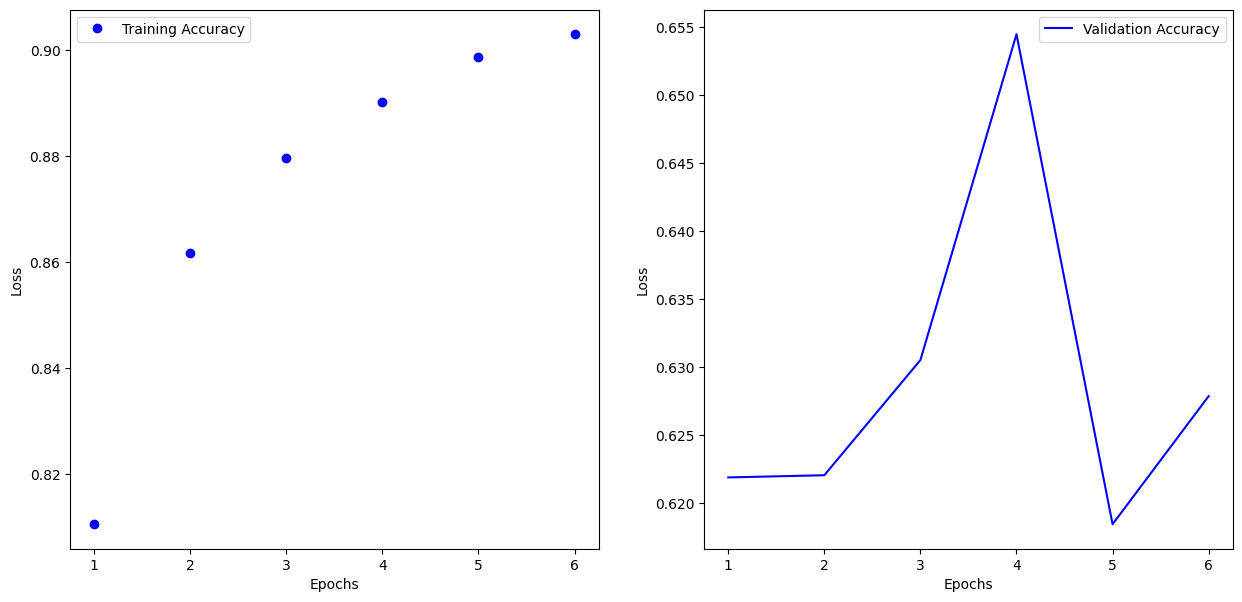

In [ ]:
# Model 1 Accuracy Plot
epochs1 = range(1, len(accuracy1) + 1)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(epochs1, accuracy1, 'bo', label='Training Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs1, val_accuracy1, 'b', label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [ ]:
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']
print(loss1, '\n', val_loss1)

[0.45326924324035645, 0.3458499312400818, 0.30679598450660706, 0.2807682156562805, 0.2595560848712921, 0.2461649626493454] 
 [1.0721408128738403, 1.1062768697738647, 0.9964559674263, 0.807806670665741, 1.0205928087234497, 1.098958134651184]


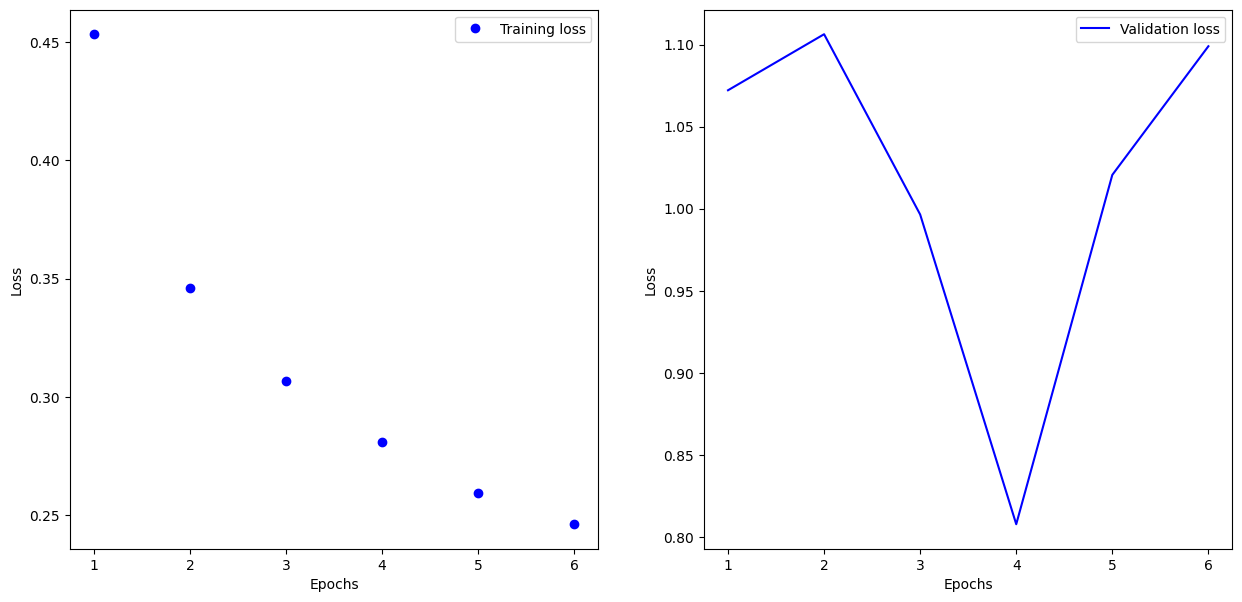

In [ ]:
# Model 1 Loss plot
epochs1 = range(1, len(loss1) + 1)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(epochs1, loss1, 'bo', label='Training loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs1, val_loss1, 'b', label='Validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

# **Attention Model**

In [ ]:
import tensorflow as tf

def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    return x

In [ ]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same", kernel_regularizer=keras.regularizers.l2(l=0.1))(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Dropout(0.5)(out)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

In [ ]:
def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def attention_unet(input_shape):
    """ Inputs """
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

In [ ]:
model2 = attention_unet(input_size)

NameError: name 'input_size' is not defined

In [ ]:
model2.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()

In [ ]:
# with tf.device('/GPU:0'):
earlystopper = EarlyStopping(patience=2, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/AML_Project/Models/model2_c2_cp_dropout.h5', verbose=1, save_best_only=True)
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-7, verbose=1)
results2 = model2.fit(X_train, Y_train, validation_split=0.2, batch_size=1, epochs=10,
                    callbacks=[earlystopper, checkpointer, reduceLROnPlateau])

NameError: name 'EarlyStopping' is not defined

In [ ]:
model2.save('/content/drive/MyDrive/AML_Project/Models/model2_c2_dropout.h5')

In [ ]:
history_dict = results2.history

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
print(accuracy, '\n', val_accuracy)

In [ ]:
# Model 2 Accuracy Plot
epochs = range(1, len(accuracy) + 1)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(epochs, accuracy, 'bo', label='Training Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [ ]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
print(loss, '\n', val_loss)

In [ ]:
# Model 2 Loss plot
epochs1 = range(1, len(loss) + 1)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

# **Testing Models**

In [ ]:
# load the Aug model
from tensorflow import keras
model1 = keras.models.load_model('/content/drive/MyDrive/AML_Project/Models/model1_c2_cp.h5')

In [ ]:
model2 = keras.models.load_model('/content/drive/MyDrive/AML_Project/Models/model2_c2_.h5')

In [ ]:
cat = img.imread('/content/content/Dataset_1/test_384x384/images/austin20_1_1.jpg')
resized_cat = resize(cat,(384,384,3))
plt.imshow(resized_cat, cmap='gray')
plt.show()

In [ ]:
pred1 = model1.predict(np.expand_dims(resized_cat, 0))
image1 = pred1.reshape(384,384)
image1.min()

In [ ]:
pred2 = model2.predict(np.expand_dims(resized_cat, 0))
image2 = pred2.reshape(384,384)
image2.min()

In [ ]:
image1.shape

In [ ]:
image2.shape

In [ ]:
plt.imshow(image1, cmap='gray')

In [ ]:
plt.imshow(image2, cmap='gray')

In [ ]:
test_path = glob.glob('/content/content/Dataset_1/test_384x384/images/*')
gt_path = glob.glob('/content/content/Dataset_1/test_384x384/gt/*')

In [ ]:
from skimage.color import rgb2gray
def calc_iou(model, test_pt, gt_pt):
  iou=[]
  for count,fn in enumerate(test_pt):
      cat = img.imread(fn)
      cat = resize(cat,(384,384,3))
      pred = model.predict(np.expand_dims(cat, 0))
      pred = pred.reshape(384,384)*255
      ret, pred = cv2.threshold(pred, 120, 255, cv2.THRESH_BINARY)

      gt = img.imread(gt_pt[count])
      gt = resize(gt,(384,384,3))
      gt = rgb2gray(gt)

      intersection = np.logical_and(gt, pred)
      union = np.logical_or(gt, pred)
      iou_score = np.sum(intersection) / np.sum(union)
      iou.append(iou_score)
      return iou



In [ ]:
iou_1 = calc_iou(model1, test_path, gt_path)
sum(iou_1) / len(iou_1)

In [ ]:
iou_2 = calc_iou(model2, test_path, gt_path)
sum(iou_2) / len(iou_2)

In [ ]:
cat = img.imread('/content/content/Dataset_1/test_384x384/images/austin20_0_11.jpg')
cat = resize(cat,(384,384,3))
plt.imshow(cat, cmap='gray')
plt.show()

In [ ]:
pred = model2.predict(np.expand_dims(cat, 0))
pred = pred.reshape(384,384)*255
ret, pred = cv2.threshold(pred, 120, 255, cv2.THRESH_BINARY)
plt.imshow(pred, cmap='gray')

In [ ]:
from skimage.color import rgb2gray
gt = img.imread('/content/content/Dataset_1/test_384x384/gt/austin20_0_11.png')
gt = resize(gt,(384,384,3))

gt = rgb2gray(gt)
plt.imshow(gt, cmap='gray')
plt.show()

In [ ]:
import numpy as np

In [ ]:
intersection = np.logical_and(gt, pred)
union = np.logical_or(gt, pred)
iou_score = np.sum(intersection) / np.sum(union)

In [ ]:
iou_score